In [143]:
# Importing Modules 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MaxAbsScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [186]:
def plot_grid(df, nrows, ncols):
    
    fix, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(data, linewidth=1)
        
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize=6)
        
    plt.tight_layout();

In [145]:
df_DJI = pd.read_csv('./DATA/INDICES/DJI_OHLC.csv', parse_dates=['Date'], infer_datetime_format=True, index_col="Date" )
df_DJI['stdev'] = df_DJI['Close'].pct_change().rolling(window=5).std()
df_DJI.dropna(inplace=True)
print(df_DJI.shape)
df_DJI.head()

(3006, 5)


,Open,High,Low,Close,stdev
Date,,,,,
2010-10-07,10968.41,10998.53,10892.76,10948.58,0.009404
2010-10-08,10948.50,11032.17,10929.28,11006.48,0.009458
2010-10-11,11006.93,11030.50,10977.90,11010.34,0.007813
2010-10-12,11010.79,11053.21,10913.84,11020.40,0.002588
2010-10-13,11022.82,11155.23,11022.07,11096.08,0.003599


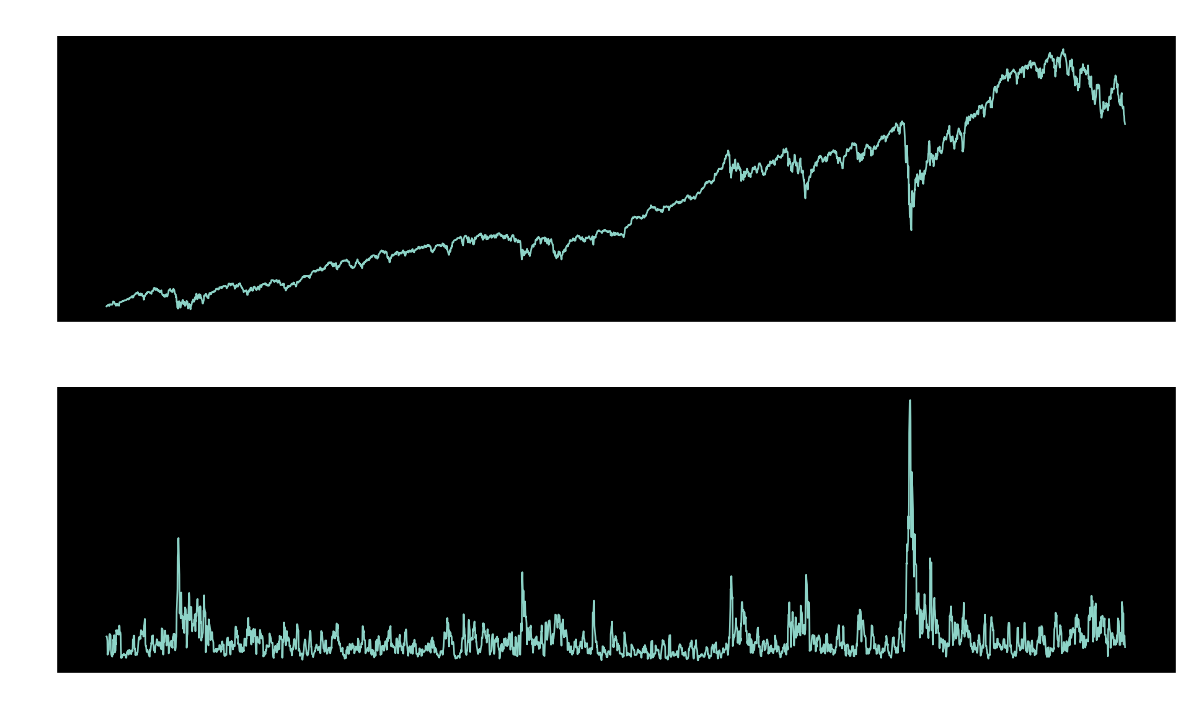

In [187]:
# Plot dataset
plot_grid(df_DJI[['Close', 'stdev']], 2, 1)

In [147]:
# Check stationarity
adfuller_res = adfuller(df_DJI['Close'].diff()[1:])

print(f'ADF Statistic (Close): {adfuller_res[0]}')
print(f'p-value: {adfuller_res[1]}')

adfuller_res = adfuller(df_DJI['stdev'][1:])

print(f'ADF Statistic (stdev): {adfuller_res[0]}')
print(f'p-value: {adfuller_res[1]}')

ADF Statistic (Close): -11.098266426386495
p-value: 3.923713594010959e-20
ADF Statistic (stdev): -7.772283516545716
p-value: 8.85553590959674e-12


In [148]:
scaler = MaxAbsScaler()
scaler.fit(df_DJI)
df_DJI_scaled = scaler.transform(df_DJI)
df_DJI_scaled = pd.DataFrame(df_DJI_scaled, columns=df_DJI.columns).dropna()

# Use first 2500 days to train model
df_train = df_DJI_scaled.iloc[:2500]

# Simulation window
window = 506
df_test = df_DJI_scaled.iloc[2500:2500+window]

display(df_train.head(3))
display(df_test.head(3))

,Open,High,Low,Close,stdev
0,0.298683,0.297638,0.297324,0.297519,0.096701
1,0.298141,0.298549,0.298321,0.299092,0.097260
2,0.299732,0.298504,0.299648,0.299197,0.080343


,Open,High,Low,Close,stdev
2500,0.746505,0.743234,0.729231,0.727266,0.104556
2501,0.727511,0.733232,0.724342,0.728687,0.115920
2502,0.726923,0.737140,0.727028,0.738430,0.150805


In [149]:
model = VARMAX(
    df_train,
    #  freq='D',
    order=(1,1),
    error_cov_type='diagonal',
    enforce_stationarity=True,
    #  seasonal_order=(0,0,0,0),
    #  mle_regression=True
    filter_concentrated=True
)

model_fit = model.fit(disp=True)

model_fit.summary()

Dep. Variable:,"['Open', 'High', 'Low', 'Close', 'stdev']",No. Observations:,2500
Model:,"VARMA(1,1)",Log Likelihood,46099.717
,+ intercept,AIC,-92077.434
Date:,"Wed, 28 Sep 2022",BIC,-91722.167
Time:,17:58:32,HQIC,-91948.455
Sample:,0,Scale,0.983
,- 2500,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.13, 0.03, 0.07, 0.43, 0.01",Jarque-Bera (JB):,"934640.18, 80651.10, 71610.90, 64116.28, 34921.37"
Prob(Q):,"0.72, 0.87, 0.79, 0.51, 0.94",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"119.23, 10.84, 10.61, 8.26, 2.06",Skew:,"-3.43, 0.63, -2.30, -1.21, 0.97"


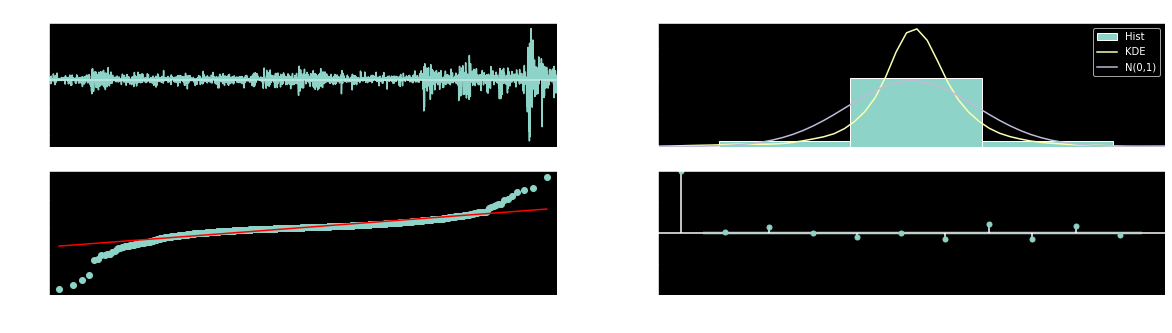

In [150]:
model_fit.plot_diagnostics(3,figsize=(20,5));

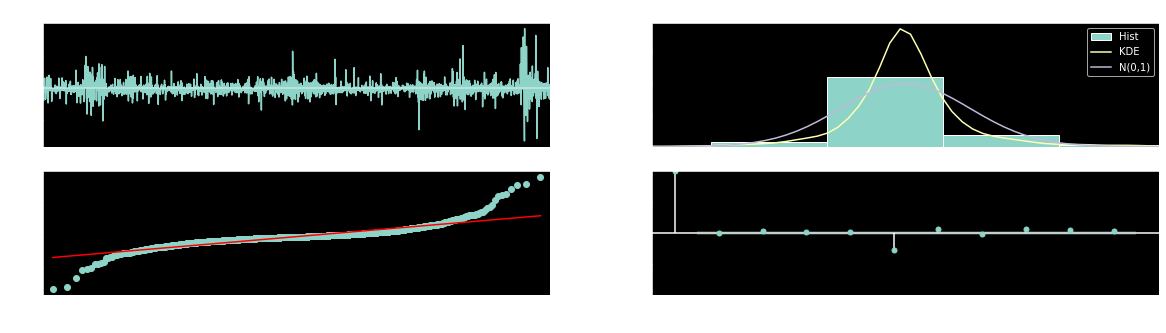

In [151]:
model_fit.plot_diagnostics(4,figsize=(20,5));

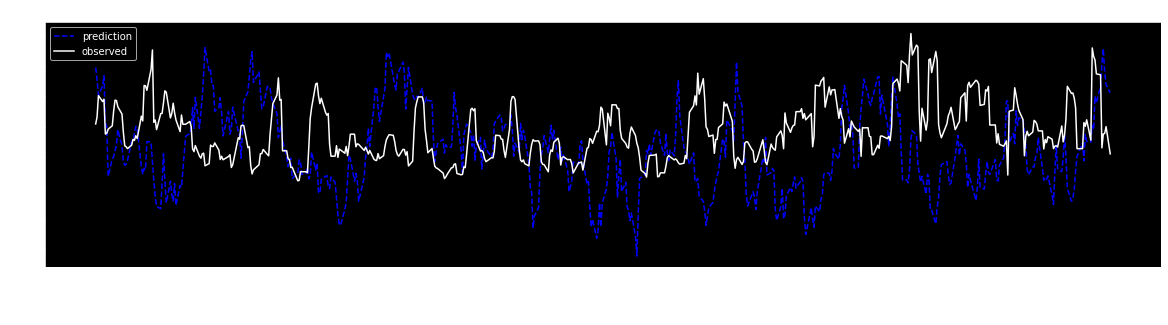

In [183]:
# plot prediction vs observed
pred = pd.DataFrame(index=df_DJI[2500:2500+window].index)
pred['prediction'] = model_fit.simulate(window).set_index(pred.index, drop=True).stdev
pred['observed'] = df_test.set_index(pred.index, drop=True).stdev
pred.plot(figsize=(20,5),title='predicted vs observed volatility',color=['blue','white'],style=['--','-']);

<AxesSubplot:title={'center':'volatility forecast error'}, xlabel='Date'>

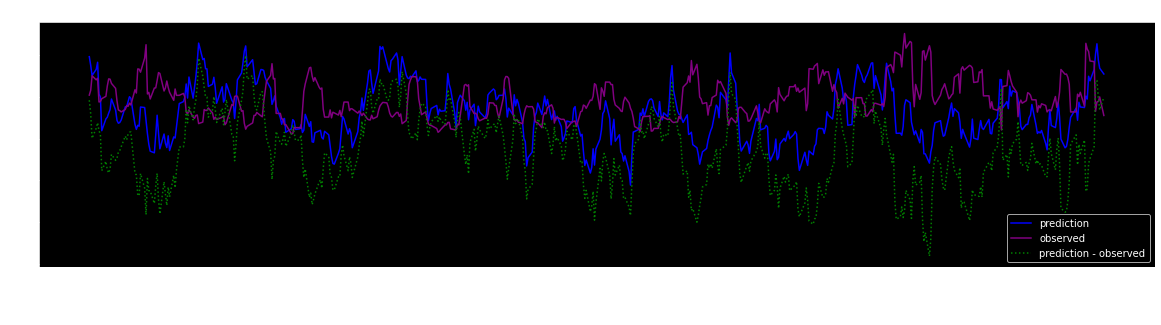

In [184]:
# plot prediction - observed
pred['prediction - observed'] = pred['prediction'] - pred['observed']
pred.plot(figsize=(20,5),title='volatility forecast error',color=['blue','purple','green'],style=['-','-',':'])

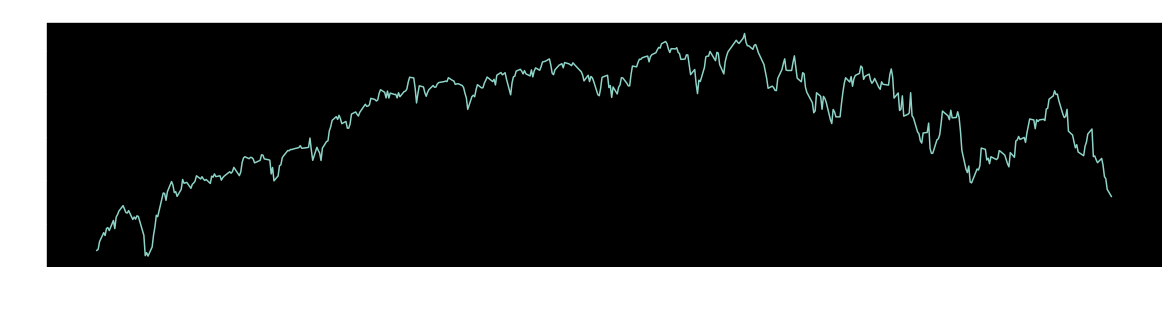

In [164]:
df_DJI['Close'].iloc[2500:2500+window].plot(figsize=(20,5), title=('DJI Close'));